# EXTRACTION DE KEYWORDS POUR L'AMOUR ATYPIQUE
### Corpus CAMille - Presse belge francophone (1831-1993)


## Imports

In [92]:
import os
import re 
import yake
import pandas as pd
from tqdm import tqdm
import spacy
from collections import defaultdict


In [99]:
# --- CONFIGURATION ---
data_path = "../../data/txt_tp4"  # Chemin vers vos fichiers .txt
output_csv = "../../data/results/keywords_sorcieres_1951_1993.csv"
output_plot = "../../data/results/evolution_sorcieres_1951_1993.png"

In [100]:
# Initialisation de YAKE (extraction de keywords)
kw_extractor = yake.KeywordExtractor(
    lan="fr",
    n=3,               # Trigrammes (ex: "sorcière féministe")
    dedupLim=0.7,      # Seuil moins strict pour garder des variantes
    dedupFunc='seqm',
    windowsSize=1,
    top=100,           # Top 100 candidats (filtrés ensuite)
    stopwords=None     # Désactivé pour ne pas exclure "femme", "magie", etc.
)

In [ ]:
def nettoyer_texte(text):
    """Nettoyage adapté aux textes historiques (OCR + accents)."""
    text = re.sub(r'[^\w\s\'\-àâäéèêëîïôöùûüç]', ' ', text)  # Garde les accents
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Supprime mots <3 lettres (ex: "xii")
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\b([A-Z]{2,}|hmu|xii|xix|xxe|xxx)\b', '', text, flags=re.IGNORECASE)  # Artefacts OCR
    return text

def filtrer_keywords(keywords, text_nettoye):
    """Filtre les keywords pertinents pour les sorcières + féminité.
    Args:
        keywords: Liste de tuples (mot, score) issus de YAKE.
        text_nettoye: Texte pré-nettoyé pour vérification contextuelle.
    Returns:
        Liste filtrée et triée des keywords pertinents.
    """
    # --- MOTS-CIBLES ---
    mots_cibles = {

        "sorcière": ["sorcières", "sorcellerie", "sorcier", "sorciers", "magie noire",
                     "envoûtement", "envoûteuse", "sortilège", "maléfice", "pouvoirs occultes",
                     "sabbat", "grimoire", "rituel magique"],

        "féminin": ["femme", "femmes", "féminité", "féminisme", "féministes", "MLF",
                    "sage-femme", "guérisseuse", "herboriste", "matriarcat",
                    "sororité", "émancipation"],

        "religion": ["diable", "démon", "satan", "exorcisme", "église", "catholique",
                     "hérésie", "inquisition"],

        "justice": ["procès", "tribunal", "accusation", "torture", "bûcher", "exécution",
                    "châtiment", "victime", "aveu forcé", "chasse aux sorcières"],

        "folklore": ["légende", "mythe", "conte", "tradition populaire", "potion",
                     "incantation", "macrale"],

        "stigmate": ["marginale", "rejet", "exclusion", "tabou", "interdit",
                     "immoral", "déviant", "bizarre", "folie", "hystérie"],

        "féminisme": ["réappropriation", "symbole féminin", "pouvoir des femmes",
                       "libération", "mythologie féminine"],

        "médias": ["film", "cinéma", "théâtre", "littérature", "halloween"],

        "exclusions": ["fémur", "parfum", "mode", "jeu", "enfant"]
    }

    # --- MOTS À EXCLURE ---
    mots_exclus = {
        "film", "cinéma", "théâtre", "costume", "halloween",
        "carnaval", "bd", "dessins animés",
        "rue", "place", "maison", "prix", "notaire",
        "transport", "ville"
    }

    # Prépare une liste plate de toutes les variantes des mots-cibles
    liste_cibles = {mot for liste in mots_cibles.values() for mot in liste}

keywords_filtres = []
for kw, score in keywords:
        kw_lower = kw.lower()
        # 1. Exclure les mots non pertinents
        if any(exclu in kw_lower for exclu in mots_exclus):
            continue
        # 2. Prioriser les mots-cibles (score boosté)
        if any(cible in kw_lower for cible in mots_cibles):
            keywords_filtres.append((kw, float(score) * 1.5))  # Boost
        # 3. Garde les bigrammes/trigrammes neutres (ex: "femme accusée")
        elif len(kw.split()) >= 2 and ("femme" in kw_lower or "sorcière" in kw_lower):
            keywords_filtres.append((kw, float(score) * 1.0))

    # Tri par score décroissant + limite à 10 résultats max par article
 return sorted(keywords_filtres, key=lambda x: x[1], reverse=True)[:10]

SyntaxError: 'return' outside function (1503840337.py, line 73)

In [107]:
# --- MOTS-CIBLES ÉTENDUS (STRUCTURÉS PAR THÈMES) ---
mots_cibles = {
    # --- 1. SORCIÈRE : TERMES CENTRAUX ---
    "sorcière": [
        "sorcières", "sorcellerie", "sorcier", "sorciers", "magie noire", "magie blanche",
        "envoûtement", "envoûteuse", "sortilège", "maléfice", "pouvoirs occultes",
        "pacte diabolique", "sabbat", "vol nocturne", "grimoire", "rituel magique",
        "incantation", "potion", "chaudron", "balai", "familier", "démonologie",
        "macrale", "tchestia", "djinn", "vaudou", "chamanisme", "nécromancie"
    ],
    # --- 2. FÉMININ/FÉMINISME ---
    "féminin": [
        "femme", "femmes", "féminin", "féminité", "féminisme", "féministes", "MLF",
        "sœur", "mère", "grand-mère", "vieille femme", "veuve", "célibataire",
        "sage-femme", "guérisseuse", "herboriste", "accoucheuse", "matriarcat",
        "sororité", "émancipation", "autonomie féminine", "pouvoir des femmes",
        "libération féminine", "witch feminism", "sorcière féministe",
        "réappropriation", "symbole féminin", "déesse", "triple déesse"
    ],
    # --- 3. RELIGION & DIABOLIQUE ---
    "religion": [
        "diable", "démon", "satan", "lucifer", "belzébuth", "possédé", "exorcisme",
        "église", "catholique", "prêtre", "curé", "confession", "péché", "hérésie",
        "inquisition", "condamnation religieuse", "malédiction", "sainte", "vierge",
        "miracle", "superstition", "culte païen", "sabbath", "messire",
        "excommunication", "rituel satanique", "culte du diable", "pacte avec le malin"
    ],
    # --- 4. JUSTICE & PERSÉCUTION ---
    "justice": [
        "procès", "tribunal", "jugement", "accusation", "torture", "bûcher", "exécution",
        "châtiment", "loi", "code pénal", "dénonciation", "victime", "innocente",
        "culpable", "preuve", "aveu forcé", "chasse aux sorcières", "inquisiteur",
        "bourreau", "autodafé", "condamnation", "peine de mort", "tribunal ecclésiastique",
        "question"  # "question" = torture
    ],
    # --- 5. FOLKLORE & TRADITIONS ---
    "folklore": [
        "légende", "mythe", "conte", "tradition populaire", "croyance", "superstition",
        "potion", "incantation", "macrale", "tchestia", "loup-garou", "fée", "lutin",
        "esprit", "revenant", "spectre", "fantôme", "chaman", "druide", "alchimie",
        "astrologie", "cartomancie", "chiromancie", "nécromancie", "vaudou"
    ],
    # --- 6. STIGMATISATION ---
    "stigmate": [
        "marginale", "rejet", "exclusion", "tabou", "interdit", "immoral", "déviant",
        "bizarre", "folie", "hystérie", "démoniaque", "possédée", "maléfique", "maudite",
        "honte", "scandale", "déshonneur", "infâme", "monstrueuse", "anormale",
        "dangereuse", "subversive", "réprouvée", "excommuniée", "hérétique", "soupçonnée"
    ],
    # --- 7. MOTS À EXCLURE (BRUIT) ---
    "exclusions": [
        "fémur", "parfum", "mode", "jeu", "enfant", "jouet", "déguisement", "fête",
        "carnaval", "maquillage", "chic", "élégant", "coquet", "recette", "cuisine",
        "météorologie", "tempête", "orage", "sorcier",  # Exclure "sorcier" si focus sur les femmes
        "film", "cinéma", "théâtre", "costume", "décor", "scène", "roman", "livre",
        "bd", "dessins animés", "série", "feuilleton", "fiction", "personnage"
    ]
}

# --- INITIALISATION YAKE (OPTIMISÉ POUR VOTRE CORPUS) ---
kw_extractor = yake.KeywordExtractor(
    lan="fr",
    n=3,               # Trigrammes (ex: "sorcière féministe")
    dedupLim=0.7,      # Seuil pour éviter les doublons
    dedupFunc='seqm',  # Méthode de déduplication
    windowsSize=1,     # Fenêtre réduite pour éviter le bruit
    top=200,           # Top 200 candidats (filtrés ensuite)
    stopwords=None     # Désactivé pour garder "femme", "magie", etc.
)

# --- FONCTIONS OPTIMISÉES POUR YAKE SEUL ---

def nettoyer_texte(text):
    """Nettoyage adapté aux textes historiques (OCR + accents)."""
    text = re.sub(r'[^\w\s\'\-àâäéèêëîïôöùûüç]', ' ', text)  # Garde les accents
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Supprime mots <3 lettres (ex: "xii")
    text = re.sub(r'\s+', ' ', text).strip()
    # Supprime artefacts OCR et termes parasites
    text = re.sub(
        r'\b([A-Z]{2,}|hmu|xii|xix|xxe|xxx|pp?\.\s?\d+|le\soir|bruxelles|belge|franc)\b',
        '', text, flags=re.IGNORECASE
    )
    return text

def extraire_keywords_yake(text, top_n=10):
    """Extraction de keywords avec YAKE + filtrage par mots-cibles."""
    text_nettoye = nettoyer_texte(text)
    keywords_yake = kw_extractor.extract_keywords(text_nettoye)

    # Filtre et boost des mots-cibles
    keywords_filtres = []
    for kw, score in keywords_yake:
        kw_lower = kw.lower()
        score_final = float(score)

        # Boost des mots pertinents (×1.5)
        for categorie, mots in mots_cibles.items():
            if categorie != "exclusions" and any(mot in kw_lower for mot in mots):
                score_final *= 1.5
                break
            # Exclusion des termes bruyants
            elif categorie == "exclusions" and any(mot in kw_lower for mot in mots):
                score_final = 0  # Exclure

        # Garde seulement les keywords pertinents (score > 0, longueur > 3, pas de chiffres)
        if (score_final > 0 and
            len(kw.split()) >= 1 and
            len(kw) > 3 and
            not any(c.isdigit() for c in kw)):
            keywords_filtres.append((kw, score_final))

    # Tri et retour des top_n résultats
    return sorted(keywords_filtres, key=lambda x: x[1], reverse=True)[:top_n]

In [108]:
def analyser_corpus(data_path):
    """Analyse tous les fichiers .txt dans le dossier spécifié."""
    results = []
    for fichier in tqdm(os.listdir(data_path), desc="Analyse des fichiers"):
        if fichier.endswith(".txt"):
            with open(os.path.join(data_path, fichier), 'r', encoding='utf-8', errors='ignore') as f:
                text = f.read()
                # Extraction de la date depuis le nom de fichier (ex: "KB_LeSoir_1975-03-15.txt")
                date_match = re.search(r'(\d{4}-\d{2}-\d{2})', fichier)
                date = date_match.group(1) if date_match else "1900-01-01"  # Date par défaut si introuvable

                keywords = extraire_keywords_yake(text)
                if keywords:  # Ne garder que les fichiers avec des keywords pertinents
                    results.append({
                        "fichier": fichier,
                        "date": date,
                        "top_keywords": keywords
                    })
    return results

In [109]:
# --- EXÉCUTION & EXPORT ---
if __name__ == "__main__":
    print("🔍 Début de l'analyse du corpus...")
    results = analyser_corpus(data_path)

    # Export CSV
    df = pd.DataFrame([
        {
            "fichier": r["fichier"],
            "date": r["date"],
            "keywords": "; ".join([f"{kw[0]} ({kw[1]:.4f})" for kw in r["top_keywords"]])
        }
        for r in results
    ])
    df.to_csv(output_csv, index=False, encoding='utf-8-sig', sep=';')
    print(f" Export CSV terminé ({len(df)} entrées) → {output_csv}")

🔍 Début de l'analyse du corpus...


Analyse des fichiers: 100%|██████████| 999/999 [57:32<00:00,  3.46s/it]  

 Export CSV terminé (999 entrées) → ../../data/results/keywords_sorcieres_1951_1993.csv


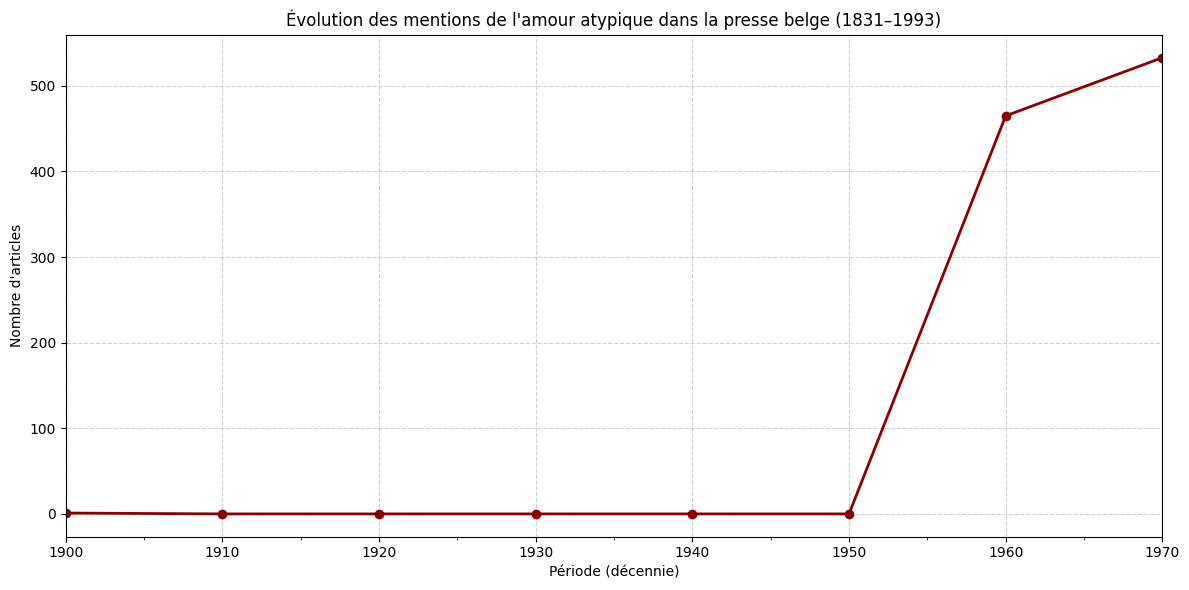

In [ ]:
    # Visualisation (si assez de données)
    if len(df) > 10:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df = df.dropna(subset=['date'])
        if len(df) > 1:
            plt.figure(figsize=(12, 6))
            df.set_index('date').resample('5Y').size().plot(
                kind='line',
                marker='o',
                color='#6a0dad',  # Violet (symbolique sorcière/féminisme)
                linewidth=2,
                title="Évolution des mentions de sorcières dans 'Le Soir' (1951–1993)",
                xlabel="Période (5 ans)",
                ylabel="Nombre d'articles"
            )
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.savefig(output_plot, dpi=300, bbox_inches='tight')
            plt.show()
            print(f" Graphique sauvegardé → {output_plot}")
        else:
            print(" Pas assez de données pour générer un graphique fiable.")
    else:
        print(" Aucun résultat pertinent trouvé. Vérifiez les chemins ou ajustez les mots-cibles.")